# Using a Professional Package: DifferentialEquations.jl

While our `euler` and `rk4` functions are fantastic for learning the fundamentals, real-world problems benefit from the power and robustness of professional-grade libraries. In the Julia ecosystem, the excellent `DifferentialEquations.jl` package is the standard.

It provides highly optimized, high-order solvers with crucial features we didn't implement in our simple functions:

1.  **Adaptive Step-Sizing:** Instead of a fixed step size $h$, you specify *error tolerances* (e.g., `abstol` for absolute tolerance and `reltol` for relative tolerance). The solver will then *automatically* choose small steps when the solution is changing rapidly and larger steps when it's smooth, maximizing both efficiency and accuracy.
2.  **Interpolation:** The package returns a continuous *solution object*, not just a discrete array of points. You can then use this object like a function to evaluate (interpolate) the high-accuracy solution at *any* time $t$ you choose.
3.  **Event Handling:** The solver can efficiently detect when the solution crosses a certain threshold (an "event") and take special actions, as we'll see.

We'll demonstrate the package by solving the same pendulum problem from the previous section. The setup has a few key differences from our manual solver:

* **RHS Function Signature:** `DifferentialEquations.jl` expects the function signature `f(y, p, t)`, where `y` is the state vector, `p` is a container for (optional) parameters, and `t` is the time. This is a different order from our `f(t, y)`!
* **Time Span:** You specify the entire simulation interval as a tuple `(t_start, t_end)`.
* **Problem Object:** You bundle the function, initial condition, and time span into an `ODEProblem` object before solving.

In [1]:
using DifferentialEquations, Plots

# Define the RHS function with the package's required signature: f(y, p, t)
# y[1] = theta, y[2] = theta'
# 'p' is for parameters, which we aren't using here, so it's just a placeholder
f(y,p,t) = [y[2], -sin(y[1])]

# Define the initial condition as a vector
y0 = [2.5, 0]

2-element Vector{Float64}:
 2.5
 0.0

Next, we specify the initial time $t_0$ and the final time $T$ as a `tspan` tuple. Notice again that we do not set a step size $h$, only the time interval we want to solve for.

In [2]:
# Set the time span from t=0.0 to t=10.0
tspan = (0.0, 10.0)

(0.0, 10.0)

Now we can create the `ODEProblem` and call `solve()`, passing our desired accuracy tolerances. The solver will automatically choose an appropriate algorithm and step sizes to meet this tolerance.

In [3]:
# 1. Define the problem by bundling the function, IC, and time span
prob = ODEProblem(f, y0, tspan)

# 2. Solve the problem
# We request a high accuracy with low absolute (abstol) and relative (reltol) tolerances.
# The semicolon ';' at the end suppresses the large output from the solver.
sol = solve(prob, abstol=1e-8, reltol=1e-8);

The resulting `sol` object holds the complete solution. We can inspect the actual discrete time steps the adaptive solver chose to take using `sol.t` and the corresponding solution vectors in `sol.u`.

In [4]:
# hcat concatenates the time vector and the solution vectors horizontally
# This shows the (t, [y1, y2]) pairs at each step the solver *actually* took.
# Look closely at the values in sol.t: the time steps are not constant!
hcat(sol.t, sol.u)

51×2 Matrix{Any}:
  0.0        [2.5, 0.0]
  0.0421484  [2.49947, -0.0252307]
  0.151258   [2.49314, -0.0908002]
  0.297367   [2.47338, -0.180062]
  0.458322   [2.43626, -0.281938]
  0.645056   [2.37206, -0.407205]
  0.847127   [2.27514, -0.554271]
  1.05526    [2.14272, -0.720961]
  1.26013    [1.97682, -0.901318]
  1.4608     [1.777, -1.09215]
  1.65596    [1.545, -1.28603]
  1.8471     [1.28108, -1.47433]
  2.03723    [0.98405, -1.64609]
  ⋮          
  7.90218    [0.302029, 1.87397]
  8.08321    [0.634695, 1.79243]
  8.26649    [0.951896, 1.6621]
  8.46039    [1.25784, 1.4893]
  8.67919    [1.56035, 1.27404]
  8.86474    [1.77959, 1.08983]
  9.06405    [1.97773, 0.900386]
  9.2614     [2.13801, 0.726442]
  9.47044    [2.27203, 0.558541]
  9.68941    [2.37662, 0.399355]
  9.92391    [2.45179, 0.244004]
 10.0        [2.46853, 0.196093]

In practice, it's much more likely you'll want to evaluate the solution at your *own* set of time points (e.g., for a smooth plot). 

This is the best part: the `sol` object acts like a continuous function! We can simply call `sol(t)` to get the highly-accurate interpolated solution at any time `t` within the `tspan`.

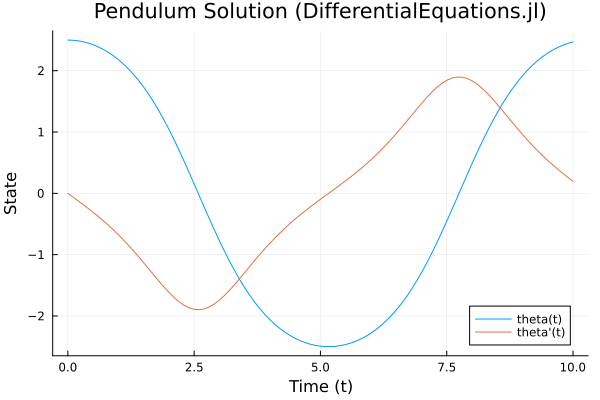

In [5]:
# 1. Create a fine, regular time grid 'tt' (from 0 to 10 with 0.1 spacing)
tt = 0:0.1:10

# 2. Get the solution at every point in 'tt'
# We use broadcasting 'sol.(tt)' to call 'sol' for each time in 'tt'
# 'ally' becomes an array of solution vectors (i.e., an array of arrays)
ally = sol.(tt)

# 3. Convert the array of vectors into a 2D matrix for plotting
# hcat(ally...) uses the 'splat' operator ... to feed each vector to hcat
# The result is a 2x101 matrix, where each column is a state [theta, theta']
ally_matrix = hcat(ally...)

# 4. Plot the results
# We plot the transpose (ally_matrix') so that the two states are plotted as lines over time
plot(tt, ally_matrix', label=["theta(t)" "theta'(t)"], 
     title="Pendulum Solution (DifferentialEquations.jl)",
     xlabel="Time (t)", ylabel="State")

## Event Handling with Callbacks

Another powerful feature is **event handling** using *Callbacks*. A callback monitors the solution and can trigger an "event" (a special action) when a specific condition is met.

As an example, suppose we want to find the *period* of the pendulum. This is a non-trivial problem, but we can find it numerically. The pendulum completes **half a period** when it swings to the other side and its angular velocity $\theta'(t)$ becomes zero for the first time (after $t=0$).

We can use a `ContinuousCallback` to tell the ODE solver to find the *exact* time when $\theta'(t)=0$ and then stop the simulation.

A `ContinuousCallback` is specified by two functions:

1.  `condition`: A function `condition(y, t, integrator)` that the solver monitors. The event will be triggered when this function's output *crosses zero*.
2.  `affect!`: A function `affect!(integrator)` that defines what action to take *when* the event is triggered.

In our case, the condition is simply $\theta'$, which is the second component of our solution vector `y[2]`.

In [6]:
# The event is triggered when this function crosses zero.
# We want to find when y[2] (our angular velocity) == 0.
condition(y, t, integrator) = y[2]

condition (generic function with 1 method)

Next, we specify what the solver should do when the condition is satisfied. We want to stop the simulation, which is done with the `terminate!` function.

In [7]:
# This 'affect!' function is called when condition(y, t, integrator) == 0.
# We tell the solver to stop the integration.
affect!(integrator) = terminate!(integrator)

affect! (generic function with 1 method)

Finally, we define the `ContinuousCallback` and pass it to the `solve` function. The solver will now stop exactly when the event occurs. The time for the half-period will be the final time in the solution, `sol.t[end]`.

In [8]:
# 1. Combine the condition and affector into a callback object
cb = ContinuousCallback(condition, affect!)

# 2. Solve the problem again, this time passing the callback
# The solver will now stop early when the condition y[2]=0 is met.
sol = solve(prob, callback=cb, abstol=1e-8, reltol=1e-8)

# 3. The simulation stopped precisely at the half-period time.
# The full period is twice this value.
half_period = sol.t[end]
println("Half period found at t = $half_period")
println("Full Period = $(2*half_period)")

Half period found at t = 5.161581432727413
Full Period = 10.323162865454826
